In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import os
# import rapids_singlecell as rsc
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import session_info
# session_info.show()

In [3]:
sc.settings.set_figure_params(dpi=120)

# Read in

In [4]:
objects_dir = '/home/kk837/rds/rds-teichlab-C9woKbOCf2Y/kk837/Foetal/anndata_objects/Xenium'
path_adata = f'{objects_dir}/C194-HEA-0-FFPE-1_Hst45-HEA-0-FFPE-1_concat_5K_filtered_raw.h5ad'
adata = sc.read_h5ad(path_adata)
print(adata.X.data[:5])
adata

[5. 1. 1. 2. 2.]


AnnData object with n_obs × n_vars = 362277 × 5001
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'n_genes', 'tissue_block_id', 'celltypist_coarse', 'conf_score_coarse', 'celltypist_coarse_fin', 'celltypist_coarse2midmod', 'conf_score_coarse2midmod', 'celltypist_mid_fin', 'celltypist_midmod2fine', 'conf_score_midmod2fine'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_me

# Log-normalise

In [5]:
adata_lognorm = adata.copy()

In [6]:
# filter genes
sc.pp.filter_genes(adata_lognorm, min_cells=3)

In [7]:
# log-normalise the count
sc.pp.normalize_total(adata_lognorm,target_sum=1e4)
sc.pp.log1p(adata_lognorm)
adata_lognorm.X.data[:5]

array([4.2093534, 2.6576407, 2.6576407, 3.3151019, 3.3151019],
      dtype=float32)

# PCA

In [8]:
# Create simple reduced dimensional space using PCA
sc.tl.pca(adata_lognorm)
adata_lognorm

AnnData object with n_obs × n_vars = 362277 × 5001
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'n_genes', 'tissue_block_id', 'celltypist_coarse', 'conf_score_coarse', 'celltypist_coarse_fin', 'celltypist_coarse2midmod', 'conf_score_coarse2midmod', 'celltypist_mid_fin', 'celltypist_midmod2fine', 'conf_score_midmod2fine'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_me

# Run Harmony

In [9]:
import scanpy.external as sce

In [12]:
%%time
sce.pp.harmony_integrate(adata_lognorm, 'tissue_block_id', basis='X_pca', adjusted_basis='X_pca_harmony')

2025-05-29 11:30:02,396 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-29 11:30:37,959 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-29 11:30:39,610 - harmonypy - INFO - Iteration 1 of 10
2025-05-29 11:32:38,887 - harmonypy - INFO - Iteration 2 of 10
2025-05-29 11:34:33,817 - harmonypy - INFO - Iteration 3 of 10
2025-05-29 11:36:26,974 - harmonypy - INFO - Iteration 4 of 10
2025-05-29 11:38:20,918 - harmonypy - INFO - Iteration 5 of 10
2025-05-29 11:40:11,757 - harmonypy - INFO - Converged after 5 iterations


CPU times: user 33min 39s, sys: 57.2 s, total: 34min 37s
Wall time: 10min 14s


In [13]:
# add to original adata
adata.uns['pca'] = adata_lognorm.uns['pca'].copy()
adata.obsm['X_pca'] = adata_lognorm.obsm['X_pca'].copy()
adata.obsm['X_pca_harmony'] = adata_lognorm.obsm['X_pca_harmony'].copy()
adata.varm['PCs'] = adata_lognorm.varm['PCs'].copy()
adata

AnnData object with n_obs × n_vars = 362277 × 5001
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'n_genes', 'tissue_block_id', 'celltypist_coarse', 'conf_score_coarse', 'celltypist_coarse_fin', 'celltypist_coarse2midmod', 'conf_score_coarse2midmod', 'celltypist_mid_fin', 'celltypist_midmod2fine', 'conf_score_midmod2fine'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_me

# Save

In [14]:
adata.write(path_adata)
adata

AnnData object with n_obs × n_vars = 362277 × 5001
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'n_genes', 'tissue_block_id', 'celltypist_coarse', 'conf_score_coarse', 'celltypist_coarse_fin', 'celltypist_coarse2midmod', 'conf_score_coarse2midmod', 'celltypist_mid_fin', 'celltypist_midmod2fine', 'conf_score_midmod2fine'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_me

# kNN graph, UMAP, Clustering

In [15]:
key_added = 'pca_harmony'
print("making kNN graph...")
sc.pp.neighbors(adata,use_rep=f"X_{key_added}",key_added=key_added)
print("computing UMAP coordinates...")
sc.tl.umap(adata, min_dist=0.2, neighbors_key=key_added)
adata.obsm[f"X_umap_{key_added}"]=adata.obsm["X_umap"] # rename the generic X_umap coordinates
del adata.obsm["X_umap"]

making kNN graph...


/home/kk837/.conda/envs/generic_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


computing UMAP coordinates...


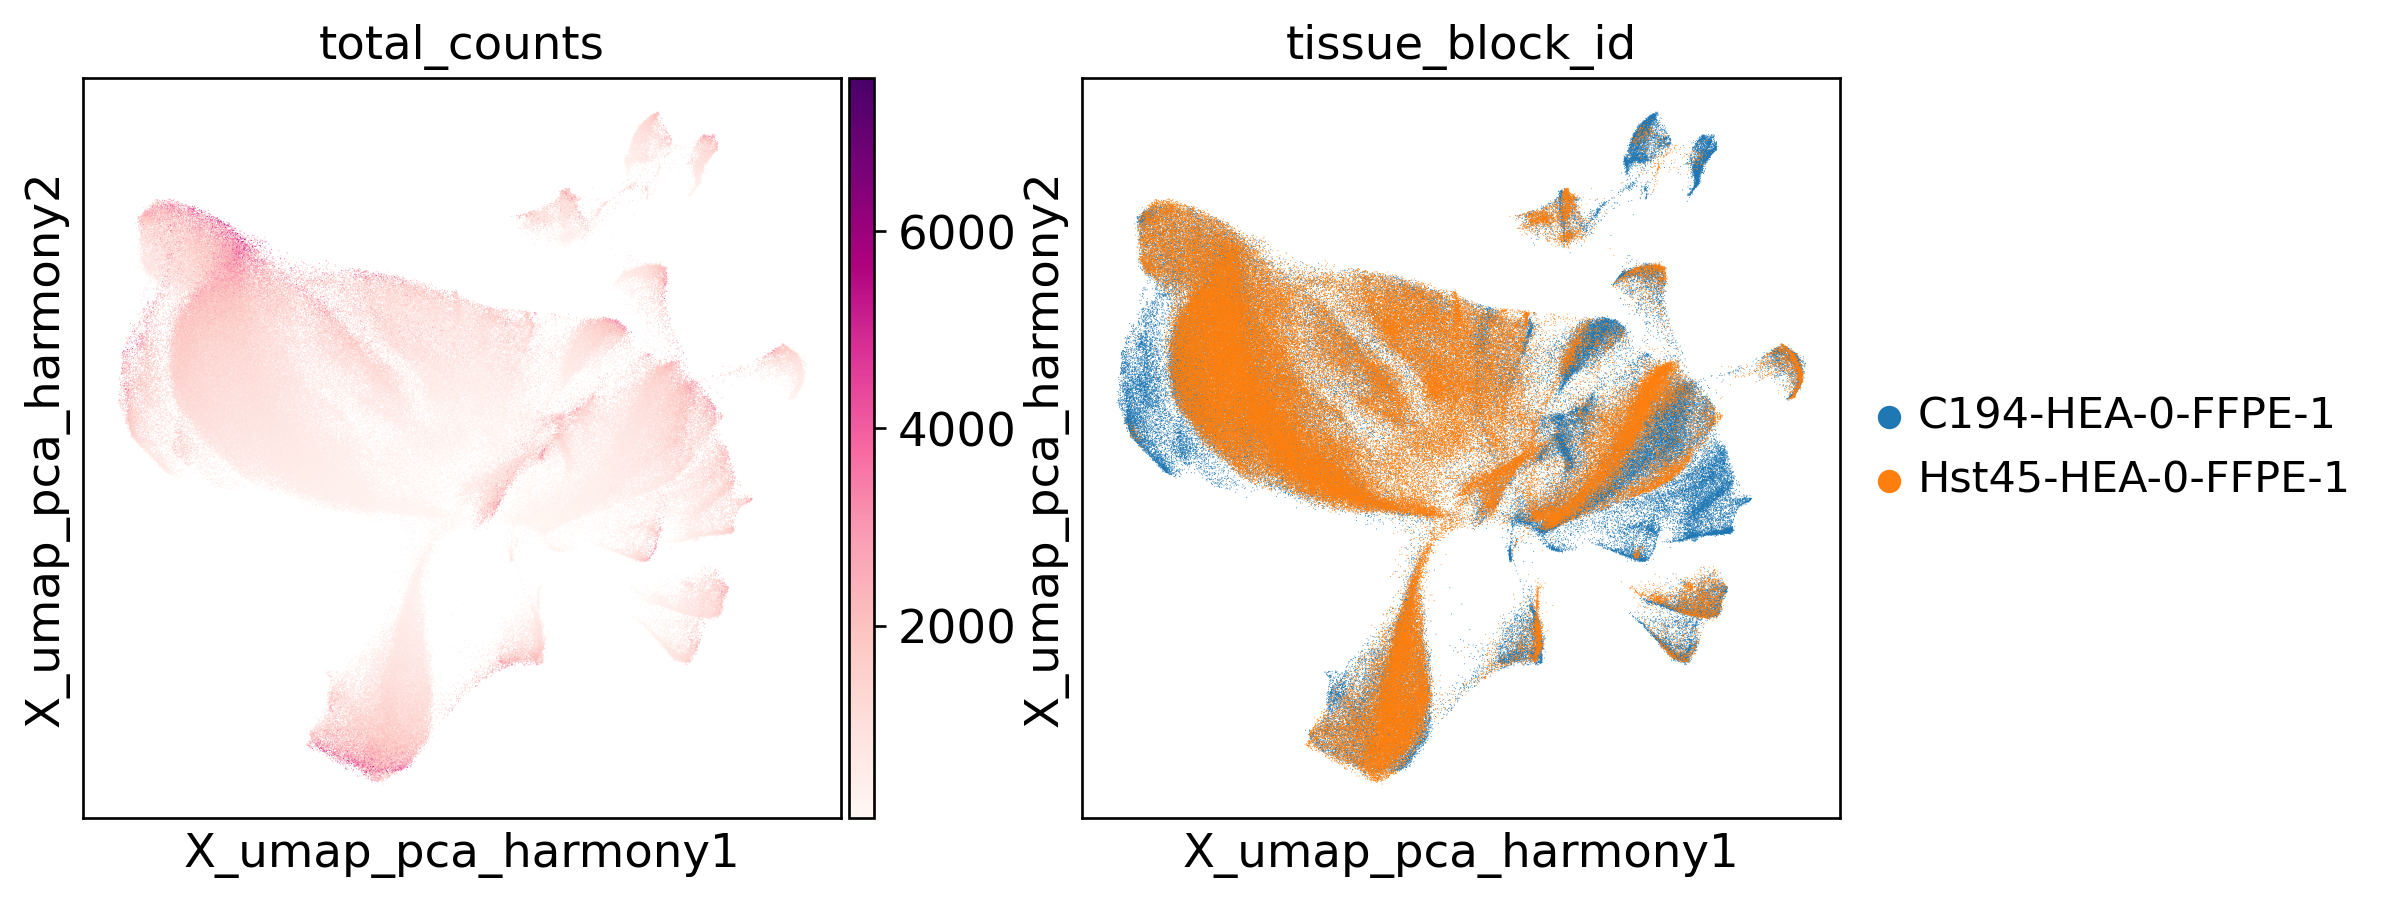

In [16]:
sc.pl.embedding(adata, basis=f"X_umap_{key_added}",
                color=['total_counts','tissue_block_id'], wspace=0.2, cmap='RdPu')

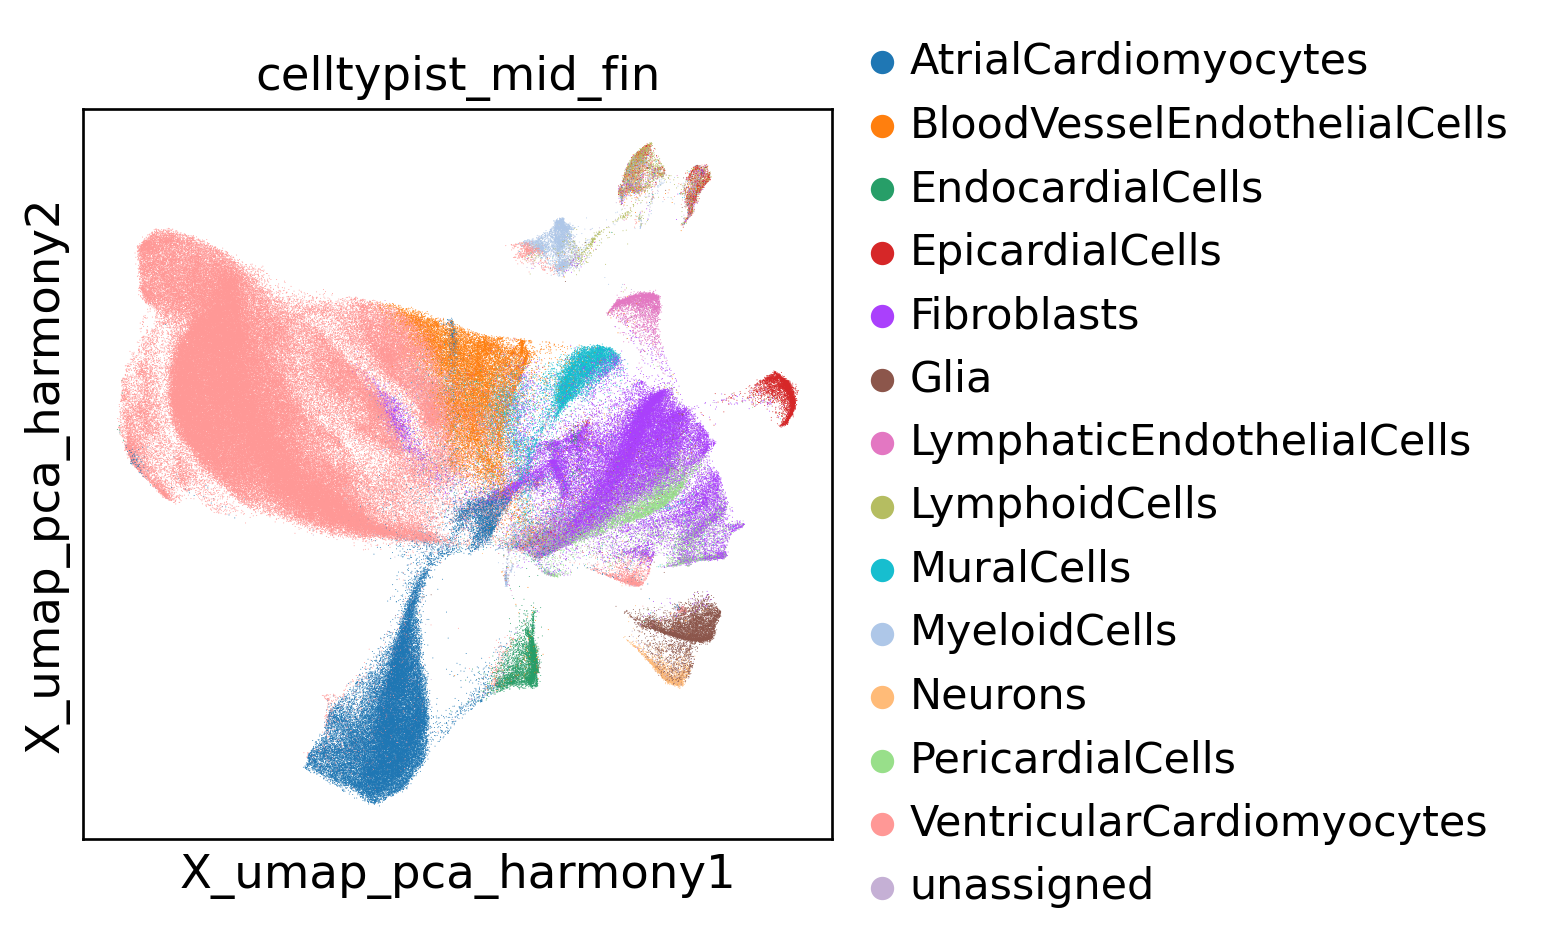

In [17]:
sc.pl.embedding(adata, basis=f"X_umap_{key_added}",
                color=['celltypist_mid_fin'], wspace=0.2, cmap='RdPu')

# Save

In [18]:
adata.write(path_adata)
adata

AnnData object with n_obs × n_vars = 362277 × 5001
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'n_genes', 'tissue_block_id', 'celltypist_coarse', 'conf_score_coarse', 'celltypist_coarse_fin', 'celltypist_coarse2midmod', 'conf_score_coarse2midmod', 'celltypist_mid_fin', 'celltypist_midmod2fine', 'conf_score_midmod2fine'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_me

In [19]:
!pwd

/rfs/project/rfs-iCNyzSAaucw/kk837/notebooks/Foetal/Xenium/5K/C194_Hst45/CamU
